In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
import pandas as pd
from matplotlib import patches

Conexión a Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Clonación de darknet

In [ ]:
#!git clone https://github.com/pjreddie/darknet/
!git clone https://github.com/kriyeng/darknet/
%cd darknet
!git checkout feature/google-colab

Cloning into 'darknet'...
remote: Enumerating objects: 10068, done.
remote: Total 10068 (delta 0), reused 0 (delta 0), pack-reused 10068
Receiving objects: 100% (10068/10068), 10.15 MiB | 10.63 MiB/s, done.
Resolving deltas: 100% (6735/6735), done.
/content/darknet
Branch 'feature/google-colab' set up to track remote branch 'feature/google-colab' from 'origin'.
Switched to a new branch 'feature/google-colab'


Este comando compila la arquitectura. Si se desea hacer alguna modificación a los archivos que componen al flujo de Darknet, debe realizarse antes de correr este comando (o volver a correrlo luego de realizar el cambio). De esta manera, la ejecución automática tomará estos archivos.

In [ ]:
!make

mkdir -p obj
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(mat_cv*, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:896:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/http_stream.cpp -o obj/http_stream.o
./src/http_stream.cpp: In member function ‘bool JSON_sende

Es recomendable a la hora de utilizar Darknet, hacer transfer learning. Esto se debe a su uso para detección de objetos. Inicializar la red con un set de pesos que corresponden a una red que detecta objetos de forma efectiva permite que el tiempo de procesamiento necesario para solucionar el problema se reduzca. Utillizamos los pesos oficiales de Joseph Redmon.

In [ ]:
#!wget https://pjreddie.com/media/files/darknet53.conv.74

--2020-07-07 15:51:19--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74     0%[                    ]   1.52M   182KB/s    eta 15m 48s^C


## Inicialización de las variables de dirección de archivos
A lo largo del trabajo, se accede a los archivos subidos a Google Drive. Se inicializan como variables para simplificar.

In [ ]:
objdata = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/obj_data.txt'
yolov3cfg = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/yolo-obj3.cfg'
preweights = '/content/darknet/darknet53.conv.74'

Durante el entrenamiento, Darknet guarda los pesos actuales cada 100 interaciones en el archivo que llama *last_weights* y crea un nuevo archivo de pesos cada 1000 interaciones. Esto fue sumamente importante ya que correr una red neuronal en Colab implica que cada 12 hs es necesario reconectar a la GPU a distancia, que si se tienen fluctuaciones en la conexión a internet se desconecta y que posee un límite de uso de GPU por cuenta. Debido a que se contaba con estas instancias intermedias del estado de los pesos, era posible retomar el entrenamiento casi sin pérdida de información e incluso desde otra cuenta con acceso a estos archivos de backup. Aquí se tienen los archivos generados con el entrenamiento de esta notebook:

In [ ]:
backup_dir = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/backup/'
last_weights = backup_dir + '/yolo-obj3_last.weights'
weights13k = backup_dir + '/yolo-obj3_13000.weights'
weights12k = backup_dir + '/yolo-obj3_12000.weights'
weights11k = backup_dir + '/yolo-obj3_11000.weights'
weights10k = backup_dir + '/yolo-obj3_10000.weights'
weights9k = backup_dir + '/yolo-obj3_9000.weights'
weights8k = backup_dir + '/yolo-obj3_8000.weights'
weights7k = backup_dir + '/yolo-obj3_7000.weights'
weights6k = backup_dir + '/yolo-obj3_6000.weights'
weights5k = backup_dir + '/yolo-obj3_5000.weights'

#Train

## Train with pjreddie's weights

In [ ]:
#!./darknet detector train '$objdata' '$yolov3cfg' '$preweights' -dont_show

yolo-obj3
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF
   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF
   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF
   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF
   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF
  13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128 0.379

## Train with last weights

In [ ]:
# Start training at the point where the last runtime finished
!./darknet detector train '$objdata' '$yolov3cfg' '$last_weights' -dont_show

yolo-obj3
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF
   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF
   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF
   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF
   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF
  13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128 0.379

## Analyze performance

In [ ]:
!./darknet detector map '$objdata' '$yolov3cfg' '$weights5k' -thresh 0.15

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF
   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF
   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF
   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF
   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF
  13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128 0.379 BF
  14 c

### mAP and IoU

Se utilizó el comando presentado anteriormente para evaluar el modelo (con el subset de validation) con los pesos correspondientes al número de iteraciones. A continuación, se presentan las métricas obtenidas indicado a qué instancia de entrenamiento corresponden. El primer número *detections_count* es el número de detecciones en las 4004 imágenes de validation. Cabe aclarar que puede haber más de una detección por imagen. El segundo número *unique_truth_count* corresponde al número de opacidades que *efectivamente había* en el subset de validation. El *class_id* es siempre 0 ya que la única clase de objetos detectados es "Lung Opacity". El valor *ap* corresponde a la precisión promedio y se vuelve a indicar como el *mAP* (mean average precision), calculado con un umbral de 0,5. Las siglas *TP* y *FP* corresponden a verdaderos y falsos positivos respectivamente, mientras que *FN* son los falsos negativos. 

Por default, Darknet descarta las detecciones cuya confidence se encuentre por debajo de 0,25. Este umbral es un hiperparámetro seteable. El *average IoU* indicado se calcula con los verdaderos positivos por lo que de ser nulos, este indicador será siempre nulo. Con el afán de mejor las métricas obtenidas, se estudió el efecto de la modificación del umbral de confidence mencionado. El *mAP* no resultó sensible a estas modificaciones, mientras que el IoU sí. La justificación para este fenómeno se explica en la sección de discusión.

El hecho de que el mAP en validation comience a bajar a partir de las 9000 iteraciones mientras que el average loss disminuía indica que a partir de entonces, el modelo comenzaba a presentar overfitting.

A continuación se presenta la condensación de los resultados obtenidos:

Iteraciones | mAP | threshold | Average IoU | TP | FP
------------- | ------------- | ------------- | ------------- | ------------- | -------------
5000 | 0,11049 | 0,25 | 0 | 0 | 0 
6000 | 0,168444 | 0,15 | 0,4321 | 40 | 23 
7000 | 0,077846 | 0,15 | 0 | 0 | 0 
8000 | 0,143928 | 0,15 | 0,4204 | 17 | 9 
9000 | 0,145824 | 0,15 | 0,2249 | 155 | 269 
10000 | 0,125933 | 0,15 | 0,2854 | 29 | 37 
11000 | 0,116969 | 0,20 | 0 | 0 | 0 
12000 | 0,123329 | 0,20 | 0,3733 | 16 | 10 
13000 | 0,121885 | 0,20 | 0,6582 | 1 | 0 

## Detalle:

### 5000: 

 detections_count = 2317, unique_truth_count = 1436  
class_id = 0, name = Lung Opacity, ap = 11.05%   	 (TP = 0, FP = 0) 

 for thresh = 0.15, precision = -nan, recall = 0.00, F1-score = -nan 
 for thresh = 0.15, TP = 0, FP = 0, FN = 1436, average IoU = 0.00 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.110490, or 11.05 % 
Total Detection Time: 1523.000000 Seconds

---



### 6000

 detections_count = 5613, unique_truth_count = 1436  
class_id = 0, name = Lung Opacity, ap = 16.84%   	 (TP = 40, FP = 23) 

 for thresh = 0.15, precision = 0.63, recall = 0.03, F1-score = 0.05 
 for thresh = 0.15, TP = 40, FP = 23, FN = 1396, average IoU = 43.21 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.168444, or 16.84 % 
Total Detection Time: 520.000000 Seconds

---



### 7000: 

detections_count = 2305, unique_truth_count = 1436  
class_id = 0, name = Lung Opacity, ap = 7.78%   	 (TP = 0, FP = 0) 

 for thresh = 0.15, precision = -nan, recall = 0.00, F1-score = -nan 
 for thresh = 0.15, TP = 0, FP = 0, FN = 1436, average IoU = 0.00 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.077846, or 7.78 % 
Total Detection Time: 517.000000 Seconds

---



### 8000:

detections_count = 3123, unique_truth_count = 1436  
class_id = 0, name = Lung Opacity, ap = 14.39%   	 (TP = 17, FP = 9) 

 for thresh = 0.15, precision = 0.65, recall = 0.01, F1-score = 0.02 
 for thresh = 0.15, TP = 17, FP = 9, FN = 1419, average IoU = 42.04 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.143928, or 14.39 % 
Total Detection Time: 519.000000 Seconds

---



### 9000:

 detections_count = 15867, unique_truth_count = 1436  
class_id = 0, name = Lung Opacity, ap = 14.58%   	 (TP = 155, FP = 269) 

 for thresh = 0.15, precision = 0.37, recall = 0.11, F1-score = 0.17 
 for thresh = 0.15, TP = 155, FP = 269, FN = 1281, average IoU = 22.49 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.145824, or 14.58 % 
Total Detection Time: 519.000000 Seconds

---



### 10000:

detections_count = 9823, unique_truth_count = 1436  
class_id = 0, name = Lung Opacity, ap = 12.59%   	 (TP = 29, FP = 37) 

 for thresh = 0.15, precision = 0.44, recall = 0.02, F1-score = 0.04 
 for thresh = 0.15, TP = 29, FP = 37, FN = 1407, average IoU = 28.54 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.125933, or 12.59 % 
Total Detection Time: 518.000000 Seconds

---



### 11000: 

 calculation mAP (mean average precision)...
4004
 detections_count = 3908, unique_truth_count = 1436  
class_id = 0, name = Lung Opacity, ap = 11.70%   	 (TP = 0, FP = 0) 

 for thresh = 0.20, precision = -nan, recall = 0.00, F1-score = -nan 
 for thresh = 0.20, TP = 0, FP = 0, FN = 1436, average IoU = 0.00 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.116969, or 11.70 % 
Total Detection Time: 521.000000 Seconds

---



### 12000: 

 detections_count = 7096, unique_truth_count = 1436  
class_id = 0, name = Lung Opacity, ap = 12.33%   	 (TP = 16, FP = 10) 

 for thresh = 0.20, precision = 0.62, recall = 0.01, F1-score = 0.02 
 for thresh = 0.20, TP = 16, FP = 10, FN = 1420, average IoU = 37.33 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.123329, or 12.33 % 
Total Detection Time: 518.000000 Seconds

---



### 13000: 

 detections_count = 3217, unique_truth_count = 1436  
class_id = 0, name = Lung Opacity, ap = 12.19%   	 (TP = 1, FP = 0) 

 for thresh = 0.20, precision = 1.00, recall = 0.00, F1-score = 0.00 
 for thresh = 0.20, TP = 1, FP = 0, FN = 1435, average IoU = 65.82 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.121885, or 12.19 % 
Total Detection Time: 517.000000 Seconds

---



### last weights: 

detections_count = 8792, unique_truth_count = 1436  
class_id = 0, name = Lung Opacity, ap = 7.30%   	 (TP = 7, FP = 15) 

 for thresh = 0.20, precision = 0.32, recall = 0.00, F1-score = 0.01 
 for thresh = 0.20, TP = 7, FP = 15, FN = 1429, average IoU = 17.75 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.072985, or 7.30 % 
Total Detection Time: 1952.000000 Seconds

# Test

Como la competencia de RSNA en la plataforma de Kaggle sigue estando activa aunque haya terminado, aún se pueden realizar submissions y obtener el score correspondiente. Por esto, desde un inicio se optó por utilizar esta herramienta para testear nuestro modelo y se dividió el subset de train disponible únicamente en train y validation, proyectando generar un archivo .csv para subir a dicha competencia al llegar a la instancia de test.



In [ ]:
test_jpg_dir = '/content/drive/My Drive/Final_redes/test_images/stage_2_test_images_jpg'
test_txt_dir = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-flipped/test.txt'
testcfg = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/yolo-obj-test.cfg'

## Predicción del subset de test

Se realizó una predicción en bloque: con este comando, se corre el comando de test para cada una de las imágenes (una línea por imagen en el archivo test.txt cuya dirección se indica en la celda anterior) y se acumulan en el archivo de salida *rsna_result#.txt*

In [ ]:
!./darknet detector test '$objdata' '$yolov3cfg' '$weights9k' -thresh 0.15 -width 1024 -height 1024 -dont_show < '$test_txt_dir' > rsna_result7.txt

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF
   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF
   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF
   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF
   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF
  13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128 0.379 BF
  14 c

## Armado del archivo para la submission en Kaggle

Para esto, se utilizó el trabajo de un estudiante de Bengaluru, Karnataka, India, publicado bajo el seudónimo *anil777* [3]. Desarrolló un conjunto de funciones disponibles en el archivo *parse_darknet_output.py* que pueden utilizarse para convertir un archivo .txt con la salida de un testeo de Darknet en un archivo .csv listo para submittearse en Kaggle como predicciones. Fue necesario que le realicemos ligeras modificaciones pero a grandes rasgos, las funciones son propiedad de él.

In [ ]:
!python parse_darknet_output.py -i 'rsna_result7.txt' -o 'submission1024_9k_7.csv'

Para estudiar lo obtenido, se importó el .csv de salida como un pandas dataframe.

In [ ]:
submission1024_7 = pd.read_csv('submission1024_9k_7.csv')

Este comando permite concluir que se detectaron opacidades pulmonares en 300 imágenes de test, ya que filtra el resultado para mostrar únicamente los registros con un prediction string no nulo.

In [ ]:
submission1024_7[submission1024_7['PredictionString'].notnull()]

,patientId,PredictionString
11,274def79-ae29-4b96-a222-4489e79d54ea,0.19
20,0382a252-b1b3-477d-bf8f-15da22a7f19c,0.17
22,2745b4cf-67c8-4f50-b4d5-9b44c073ea61,0.17
53,1e8ea4d6-568b-4aae-b91b-1a1f0d13dbd2,0.17
62,034bda9f-cd72-457e-8dfc-e7ca6634fabe,0.16
...,...,...
2970,0d0a219a-f091-430b-a0c4-6a90faa1636c,0.17
2976,046a9f1a-abb6-4e75-94f5-a98a197a3ee9,0.23
2979,285b5785-cab1-4713-b345-51dc7e5bde93,0.20
2992,1cef67f6-69f2-4e9f-9bfb-7fbbbd0012dc,0.22


El prediction string está compuesto de la confidence de la detección y las coordenadas de la bounding box (x1 e y1 son las coordenadas de la esquina superior izquierda y width y height son el ancho y alto de la bounding box, todos expresados en número de píxeles):

< confidence > < x1 > < y1 > < width > < height >

En nuestro caso, estas coordenadas se imprimen siempre con el mismo número de posiciones. Esto hace que se impriman como números con espacios que los separan por demás. Hay que procesar la salida obtenida para prepararla para la submission, eliminando estos espacios.

In [ ]:
new_preds = [' '.join([str(float(s)) for s in p.split(' ') if len(s)>0])  if isinstance(p,str) else np.NaN for p in submission1024_6['PredictionString']] 
df_submission_processed = submission1024_6.copy()
df_submission_processed['PredictionString'] = new_preds

Por último se guarda el csv resultante. Sin embargo, nunca conseguimos obtener un score distinto de 0 al publicar en Kaggle. Luego de confirmar que estábamos armando los prediction strings de forma adecuada, concluimos que se debe a este problema de escala.

In [ ]:
df_submission_processed.to_csv('submission_1024_6_processed.csv',index=False)

# Exploración de resultados



Al estudiar la submission obtenida como se detalló, no se obtuvieron los resultados esperados. Originalmente, se observó que los bounding boxes parecían ***fuera de escala***. 

Se arribó a esta conclusión debido a que en todos los casos donde la red detecta opacidades pulmonares, éstas se encuentran siempre en la esquina superior izquierda de la imagen y tienen un área ligeramente inferior. En caso de ser más de una, se observa que su posición se asemeja a la posición de los pulmones. Aquí cabe destacar que las anotaciones de opacidades pulmonares en el subset de train (que nuestras predicciones deberían imitar) están etiquetadas abarcando una gran proporción de los pulmones. 

Dado que la documentación de Darknet no es exhaustiva, desconocíamos cuál era el código que debíamos revisar. No encontramos ninguna publicación en internet de alguien que se haya encontrado con un problema con la escala aparente de los bounding boxes. Sin embargo, estudiando los archivos de Darknet, dentro de la carpeta *src*, se tiene el archivo *image.c* donde hay está la función *draw_detections_v3* donde se puede acceder a las coordenadas de los bounding boxes y luego, éstas pueden imprimirse. Estudiando los resultados de imprimir las coordenadas de todas las predicciones correspondientes al subset de test, se confirmó nuestra conclusión anterior de que la totalidad de las bounding boxes predecidas no superaban los 700 píxeles de ancho y alto. 

Sin embargo, con la orientación de Cande Mosquera, nos dimos cuenta que el hecho de que ninguna de *esas* bounding boxes que estábamos estudiando superase los 700 píxeles no aseguraba que nuestro modelo no pudiese indicar detecciones en el área restante de la imagen. 

El ganador de la competencia de Kaggle utilizó un valor de 0,15 para el umbral de la confidencia de una detección. Debido a que encontramos ese dato y con el valor default no se detectaba prácticamente ninguna opacidad, decidimos setearlo el umbral a 0,15. Para testear nuestra teoría que un problema de escalas, redujimos el umbral a cero. Como era de esperarse, se detectaron opacidades a lo largo de toda la imagen, lo cual nos llevó a rechazar nuestra hipótesis original de problemas de escala.

Al correr el comando de test para una imagen, se crea de forma automática archivo .jpg en la carpeta de contenidos titulado "predictions.jpg". Se crearon dos funciones que utilizan esta imagen para explorar los resultados obtenidos.

## Predict and Show
Esta función imprime la predicción de la red (predictions.jpg) para una imagen dada (dirección de google drive) junto a la imagen original. El mejor mAP en validation corresponde a 6000 iteraciones de entrenamiento, seguido por 9000. Se observaron los resultados obtenidos con estas dos instancias de entrenamiento, con las de 12000 y con *last_weights*. Los mejores resultados se obtuvieron con 9k, por lo que se utilizaron estos pesos a partir de entonces. 

In [ ]:
def PredictandShow(image_loc):
  original_img = cv2.imread(image_loc)
  original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
  result = !./darknet detector test '$objdata' '$yolov3cfg' '$weights9k' '$image_loc' -thresh 0.15 -dont_show
  print(result[-1])
  confidence = ''
  if(('Lung Opacity' in result[-1]) & ('%' in result[-1])):
    confidence = result[-1]
  
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))                 
  newImage = cv2.imread('predictions.jpg')
  new_img = cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB)
  ax[0].imshow(original_img)
  ax[0].axis('off')
  ax[1].imshow(new_img)
  ax[1].axis('off')
  ax[1].set_title(confidence, fontsize=30, color="green")

Los resultados que se presentan a continuación corresponden a las imágenes del subset de test, cuyas anotaciones no disponíamos. Debido a que no se consiguió obtener un score no nulo con la *Late Submission*, no se podían calcular métricas para evaluar el desempeño del modelo en el subset de test y se prosiguió a estudiar los resultados obtenidos visualmente. Se observó que como mucho habían dos opacidades por imagen y su forma se asemeja a la de los pulmones de la imagen, solo que de menor tamaño y ubicados en la esquina superior izquierda. 

Lung Opacity: 16%


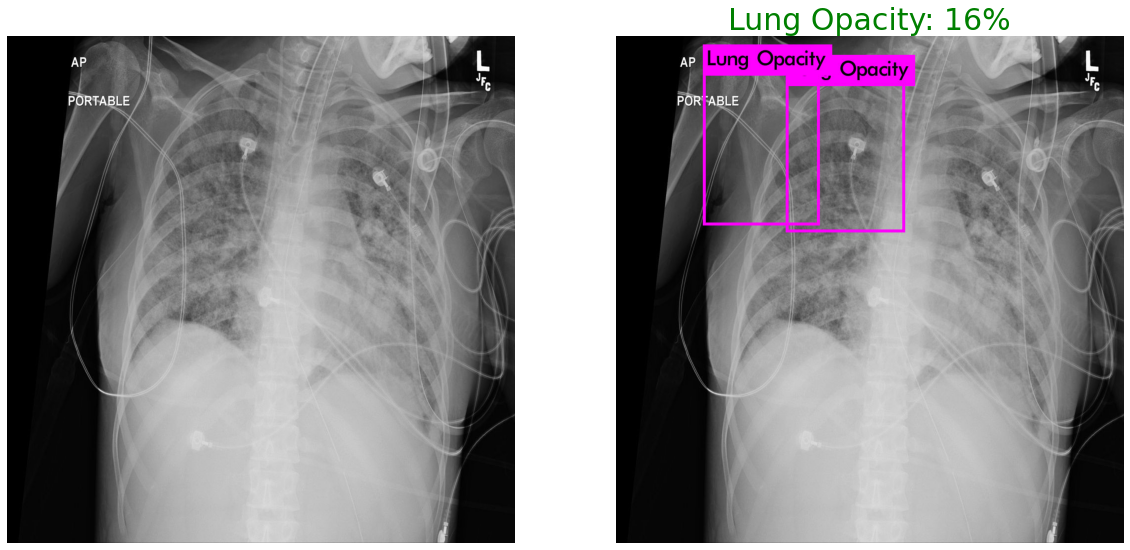

In [ ]:
PredictandShow('/content/drive/My Drive/Final_redes/test_images/stage_2_test_images_jpg/00fe1990-071e-4f90-b8c5-08fc94ff40e3.jpg')

Lung Opacity: 16%


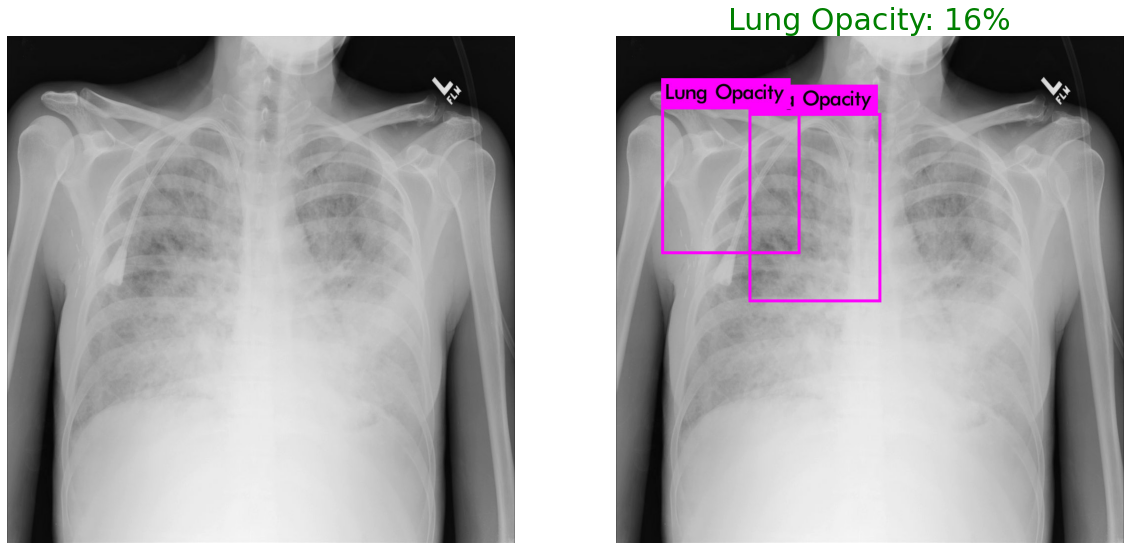

In [ ]:
PredictandShow('/content/drive/My Drive/Final_redes/test_images/stage_2_test_images_jpg/312ce1ee-4aee-42da-96dd-0371a8430824.jpg')

Lung Opacity: 18%


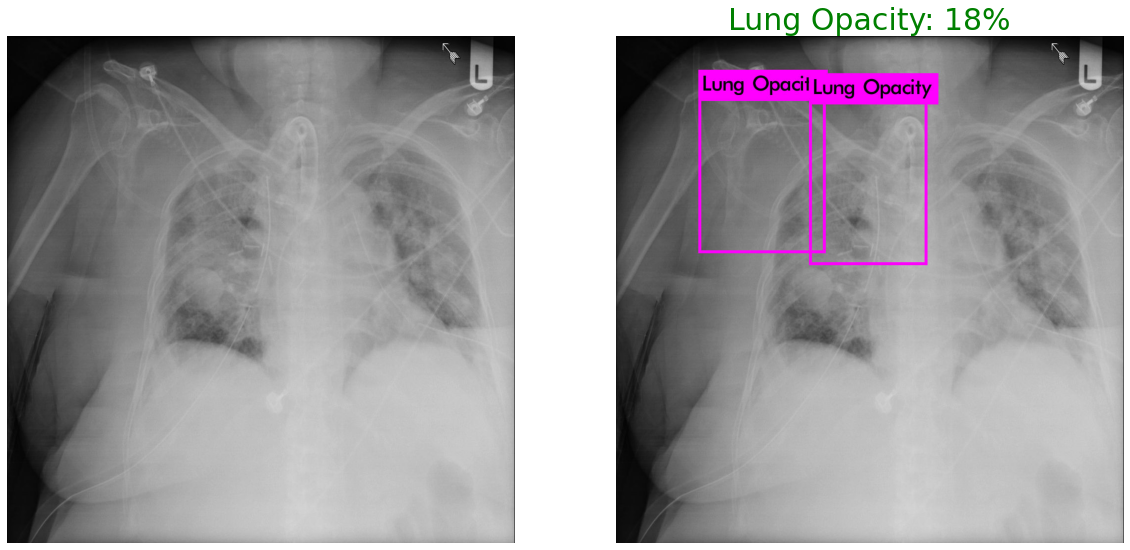

In [ ]:
PredictandShow('/content/drive/My Drive/Final_redes/test_images/stage_2_test_images_jpg/01036427-2c3e-4a79-b472-2c7bca1efa86.jpg')

## Umbral de confidencia nulo

A continuación, se elige una imagen aleatoria de test y se predicen opacidades pulmonares son un umbral de confidence mínima de 0. Como esperado, se observa que la imagen resultante está cubierta de predicciones, demostrando que el modelo no tiene una limitación espacial para la detección de opacidades.

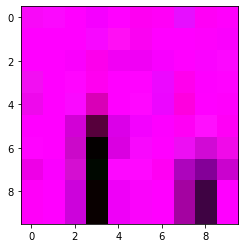

In [ ]:
img_dir = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/data/obj/06b52ffd-71b8-429a-a284-bb39240ed343.jpg'

!./darknet detector test '$objdata' '$yolov3cfg' '$weights9k' '$img_dir' -thresh 0 -dont_show

prediction = cv2.imread('predictions.jpg')
prediction = cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB)
plt.imshow(prediction)

Al correr con un umbral ligeramente mayor, se observa que se detectan muchas más opacidades en la imagen pero sobre todo, que estas no se encuentran confinadas en la esquina superior izquierda de la misma.

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF
   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF
   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF
   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF
   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF
  13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128 0.379 BF
  14 c

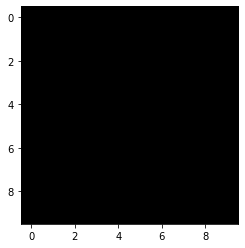

In [ ]:
!./darknet detector test '$objdata' '$yolov3cfg' '$weights9k' '$img_dir' -thresh 0.01 -dont_show

prediction = cv2.imread('predictions.jpg')
prediction = cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB)
plt.imshow(prediction)

## Actual versus Predict
Esta función solo puede utilizarse con imágenes etiquetadas. En este caso, no se puede acceder a las etiquetas de las imágenes de test ya que RSNA no las comparte. Por esto no se puede utilizar con imágenes de test. Se muestran los resultados obtenidos con imágenes de validation. En la misma imagen, se presenta la predicción del modelo como recuadros color rosa y las anotaciones de los profesionales como recuadros verdes.

In [ ]:
def ActualvsPredict(patientid):
  image_loc = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/data/obj/'+patientId+'.jpg'
  result = !./darknet detector test '$objdata' '$yolov3cfg' '$weights9k' '$image_loc' -thresh 0.15 -dont_show
  print(result)
                   
  newImage = cv2.imread('predictions.jpg')
  newImage = cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB)
  #add axes to the image
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.axis('off')

  # read and plot the image
  annotations = pd.read_csv('/content/drive/My Drive/Final_redes/RN__TP_Final/stage_2_train_labels.csv')
  image = newImage
  plt.imshow(image)

  # iterating over the image for different objects
  for index,row in annotations[annotations.patientId == image_patientid].iterrows():
            
      edgecolor = 'g'
      ax.annotate('Annotated', xy=(row.x-40,row.y+20))
          
      # add bounding boxes to the image
      rect = patches.Rectangle((row.x,row.y), row.width, row.height, edgecolor = edgecolor, facecolor = 'none')
      
      ax.add_patch(rect)

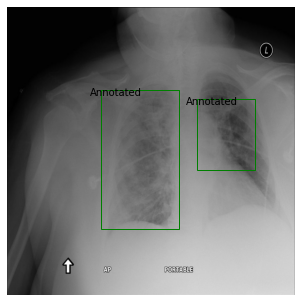

In [ ]:
ActualvsPredict('06df5d57-6f34-43c0-99ad-b9b5f9346cbd')

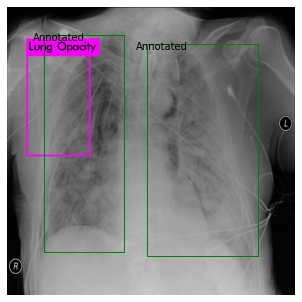

In [ ]:
ActualvsPredict('08da8f40-b186-473b-9fa3-1caa4ecdc02b')

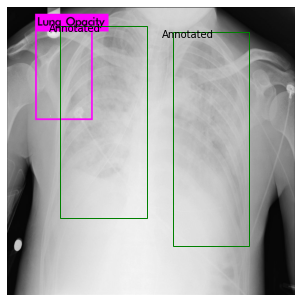

In [ ]:
ActualvsPredict('0c8458d8-25e6-44e5-946e-cf729240df59')

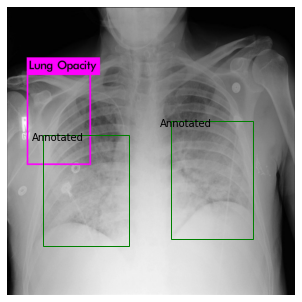

In [ ]:
ActualvsPredict('16e5a578-1e41-4fa1-ba13-bf18051625cc')

# Bibliografía


[1]   Joseph Redmon, Ali Farhadi (2013-2016). *Darknet: Open Source Neural Networks in C.* Available on: http://pjreddie.com/darknet/.

[2]   Data Science Authority. *Blood Cells Detection with YOLOV3 Darknet*. Available on: https://www.datascienceauthority.com/post/blood-cells-detection-with-yolov3.

[3]   anil777, Student in Institute of Technology in Bombay, born in Bengaluru, Karnataka, India. *YOLOv3-RSNA Starting Notebook*. Available on: https://www.kaggle.com/anil777/yolov3-rsna-starting-notebook.

